# Risk Factor Clinical Classifier

This classifier takes patient answers to the Lung Space clinical survey and predicts the chance of cancer.

## Import dataset and build dataframe

In [119]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

df = pd.read_csv('../data/lungspace/package-nlst-1193.2024-02-20/participant_d040722.csv')


# Breakdown of positive and negative sample size
print("positive: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 1].to_list()), " negative: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 0].to_list()))

# Features
features_demographic = ['age', 'weight', 'height', 'gender', 'educat', 'ethnic', 'race']
features_smoking = ["cigar","cigsmok","pipe","pkyr","smokeage","smokeday","smokelive","smokework","smokeyr"]
features_screening = ['num_screens']
features_follow_up_procedures = ["biop0","biop1","biop2","bioplc","invas0","invas1","invas2","invaslc","medcomp0","medcomp1","medcomp2","medcomplc","mra_stat0","mra_stat1","mra_stat2","no_proc_reas0","no_proc_reas1","no_proc_reas2","proc0","proc1","proc2"]
features_work_history = ["resasbe","resbaki","resbutc","reschem","resfarm","resfire","resflou","resfoun","reshard","respain","ressand","resweld","wrkasbe","wrkbaki","wrkbutc","wrkchem","wrkcoal","wrkcott","wrkfarm","wrkfire","wrkflou","wrkfoun","wrkhard","wrkpain","wrksand","wrkweld"]
features_disease_history = ["ageadas","ageasbe","agebron","agechas","agechro","agecopd","agediab","ageemph","agehear","agehype","agepneu","agestro","agetube","diagadas","diagasbe","diagbron","diagchas","diagchro","diagcopd","diagdiab","diagemph","diagfibr","diaghear","diaghype","diagpneu","diagsarc","diagsili","diagstro","diagtube"]
features_family_history = ["fambrother","famchild","famfather","fammother","famsister"]
features_alcohol = ["acrin_alc_curr","acrin_alc_ever","acrin_drink24hr","acrin_drinknum_curr","acrin_drinknum_form","acrin_drinkyrs_curr","acrin_drinkyrs_form","acrin_lastdrink","lss_alcohol_freq","lss_alcohol_num"]
output_column = ['lung_cancer']


positive:  2058  negative:  51394


/tmp/ipykernel_8696/3375708775.py:8: DtypeWarning: Columns (239,240,348) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/lungspace/package-nlst-1193.2024-02-20/participant_d040722.csv')


## Choose features to include

### Features: Demographics and Smoking

- Random forest (default): 99.8% accuracy
- K Nearest Neighbor: 94% accuracy
- Logistic Regression: 70% accuracy

In [120]:
# dataset_columns = features_demographic + features_smoking + output_column


### Features: Demographics, Smoking, Work History, Family History, Alcohol

- Random forest (default): 99.9% accuracy
- K Nearest Neighbor (3 neighbors): 94%
- Logistic Regression: 64%

In [121]:
# dataset_columns = features_demographic + features_smoking + features_work_history + features_family_history + features_alcohol + output_column


### Features: Demographics, Work History, Family History, Alcohol

- Random forest (default): 98% accuracy
- KNN (3 neighbors): 93% accuracy
- Logistic Regression: 59% accuracy

In [122]:
dataset_columns = features_demographic + features_work_history + features_family_history + features_alcohol + output_column


## Remove null values and add weight/height field

In [123]:
# Build dataframe
df = df[dataset_columns]
for i in dataset_columns[:]:
  if df[i].isna().sum() > 500:
    df = df.drop(i, axis=1)
    dataset_columns.remove(i)

# print(df.isnull().sum(axis = 0).sort_values(ascending=False).to_string())

df = df.dropna()

df.insert(2, 'weight_div_height', df['weight'] / df['height'])

print(df)


       age  weight  weight_div_height  height  gender  educat  ethnic  race  \
0       70   134.0           1.914286    70.0       1       2       2     1   
1       66   175.0           2.573529    68.0       1       3       2     1   
2       64   180.0           2.571429    70.0       1       3       2     1   
3       60   205.0           2.928571    70.0       1       5       2     1   
4       64   220.0           3.283582    67.0       1       2       2     1   
...    ...     ...                ...     ...     ...     ...     ...   ...   
53447   73   206.0           3.218750    64.0       2       3       2     1   
53448   66   175.0           2.464789    71.0       1       2       2     1   
53449   56   172.0           2.388889    72.0       1       5       2     1   
53450   69   210.0           3.088235    68.0       1       4       2     1   
53451   57   220.0           3.188406    69.0       1       7       2     1   

       wrkasbe  wrkbaki  ...  wrkcott  wrkfarm  wrk

## Downsample the negative samples to balance the dataset

In [124]:
# # Determines how many negative samples to include in the dataset
# # The frac value determines the percent of negative values that are excluded
# df = df.drop(df.query('lung_cancer == 0').sample(frac=.95).index)

# df = df[df[dataset_columns] >= 0]
# # print(df.loc[df.apply(lambda row: all(value < 0 for value in row), axis=1)])
# df = df.dropna()
# print(df)


## Duplicate the positive examples to balance the dataset

In [125]:
# Duplicate the positive samples to balance the dataset

df_positives = df[df['lung_cancer'] == 1]
print(df_positives)
print(len(df_positives['lung_cancer'].to_list()))

while len(df[df['lung_cancer'] == 1]['lung_cancer'].to_list()) < len(df[df['lung_cancer'] == 0]['lung_cancer'].to_list()):
  df = pd.concat([df, df_positives])

print(df)
print("positive: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 1].to_list()), " negative: ", len(df['lung_cancer'].loc[df['lung_cancer'] == 0].to_list()))


       age  weight  weight_div_height  height  gender  educat  ethnic  race  \
11      61   142.0           2.119403    67.0       2       7       2     1   
48      74   190.0           2.676056    71.0       2       4       2     1   
54      67   165.0           2.357143    70.0       1       6       2     1   
146     68   197.0           2.897059    68.0       1       1       2     1   
157     65   189.0           2.779412    68.0       1       5       2     1   
...    ...     ...                ...     ...     ...     ...     ...   ...   
53381   60   169.0           2.600000    65.0       2       4       2     1   
53391   69   135.0           2.076923    65.0       2       5       2     1   
53395   56   195.0           2.785714    70.0       1       3       2     1   
53430   61   190.0           2.638889    72.0       1       4       2     1   
53443   57   230.0           3.593750    64.0       2       7       2     1   

       wrkasbe  wrkbaki  ...  wrkcott  wrkfarm  wrk

## Define models

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Model names
names = [
    "Nearest Neighbors",
    "Linear SVM",
    # "RBF SVM",
    # "Gaussian Process",
    "Decision Tree",
    # "Random Forest",
    # "Neural Net",
    # "AdaBoost",
    "Naive Bayes",
    "Logistic Regression"
    # "QDA",
]

# Models
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    # SVC(gamma=2, C=1, random_state=42),
    # GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    # RandomForestClassifier(
    #     max_depth=5, n_estimators=10, max_features=1, random_state=42
    # ),
    # MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    # AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    LogisticRegression(random_state=0)
    # QuadraticDiscriminantAnalysis(),
]


# Use predict lung_cancer column
# X = df[['age', 'weight', 'height', "cigar","cigsmok","pipe","pkyr","smokeage","smokeday","smokelive","smokework","smokeyr","num_screens"]]
X = df[dataset_columns[:-1]]
y = df[['lung_cancer']]

# Spli training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

print(y_train)
print(y_test)

print("positive training sample: ", len(list(filter(lambda x: x == 1.0, y_train['lung_cancer'].to_list()))))
print("negative training sample: ", len(list(filter(lambda x: x == 0.0, y_train['lung_cancer'].to_list()))))
print("positive training sample: ", len(list(filter(lambda x: x == 1.0, y_test['lung_cancer'].to_list()))))
print("negative training sample: ", len(list(filter(lambda x: x == 0.0, y_test['lung_cancer'].to_list()))))


       lung_cancer
44912            0
28834            0
45683            1
42746            0
7174             0
...            ...
51949            1
41875            1
52973            1
872              0
15939            0

[62230 rows x 1 columns]
       lung_cancer
30517            0
7430             1
35419            1
26904            1
6340             1
...            ...
2169             1
46308            1
6063             1
19842            0
23840            1

[41487 rows x 1 columns]
positive training sample:  31736
negative training sample:  30494
positive training sample:  21096
negative training sample:  20391


## Test models and plot confusion matrices

The goal is to minimize the number of false negative predictions.

In [127]:
# for name, clf in zip(names, classifiers):
#   clf = make_pipeline(StandardScaler(), clf)
#   clf.fit(normalize(X_train), y_train)
#   y_pred = clf.predict(normalize(X_test))

#   score = accuracy_score(y_test, y_pred)
#   conf_matrix = confusion_matrix(y_test, y_pred)
#   disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
#   disp.plot()
#   print("Model: ", name, " score: ", score)


## Get confidence of each prediction with `predict_proba()`

/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model:  Logistic Regression  score:  0.5958975100633933


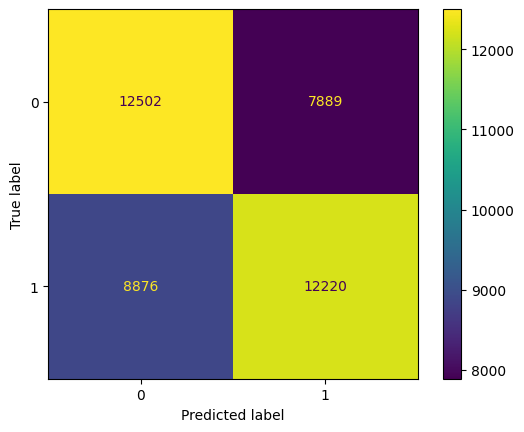

In [128]:
# # Fit logistic regression model
# model = LogisticRegression(random_state=0)
# model.fit(X_train, y_train)

# # Get confidence intervals for each prediction
# y_pred_prob = model.predict_proba(X_test)
# # Get predicted values
# y_pred = model.predict(normalize(X_test))

# # Get prediction accuracy
# score = accuracy_score(y_test, y_pred)
# # Get breakdown of false/true positives and false/true negatives
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Display results
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
# disp.plot()
# print("Model: ", name, " score: ", score)

clf = m = LogisticRegression(random_state=0)
clf = make_pipeline(StandardScaler(), clf)
clf.fit(normalize(X_train), y_train)
y_pred = clf.predict(normalize(X_test))
y_pred_prob = clf.predict_proba(X_test)

score = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
print("Model: ", "Logistic Regression", " score: ", score)


## Rank features used 

In [129]:
# Create lists of feature names and coefficients
column_labels = X_train.columns.tolist()
coef = m.coef_.squeeze().tolist()

# Zip together
labels_coef = list(zip(column_labels, coef))
# Order by most significant features (positive or negative)
feature_ranks = sorted(labels_coef, key=lambda x: abs(x[1]), reverse=True)

print(feature_ranks)


[('age', 0.6782410526514092), ('height', -0.3953297736550563), ('gender', -0.26638995915982094), ('weight', -0.22314267826130055), ('educat', -0.05497148369805817), ('race', -0.05228957197445494), ('wrkchem', 0.04285549020595216), ('wrkfire', 0.039205612824298235), ('wrksand', 0.037887556720755826), ('wrkfoun', 0.036215869196236025), ('ethnic', -0.02747561392532397), ('wrkweld', 0.02483858531723694), ('wrkcoal', 0.022108979340120117), ('wrkflou', 0.020191875638805822), ('wrkcott', 0.02006283077458046), ('wrkbaki', -0.016413372974811016), ('wrkasbe', 0.014301711439241634), ('wrkhard', 0.006427694745421699), ('wrkfarm', 0.006087840499138602), ('wrkpain', -0.005378738653991265), ('wrkbutc', -0.0009826688013202963)]


## Compare compare the probabilities of false positives and false negatives to true positives and true negatives

In [130]:
true_negative_probs = []
false_negative_probs = []
true_positive_probs = []
false_positive_probs = []

y_pred_list = y_pred.tolist()
y_pred_prob_list = y_pred_prob.tolist()
y_test_list = y_test['lung_cancer'].tolist()

for i in range(len(y_test)):
  # true negative
  if y_pred_list[i] == 0 and y_test_list[i] == 0:
    true_negative_probs.append(y_pred_prob_list[i][0])
  # false negative
  elif y_pred_list[i] == 0 and y_test_list[i] == 1:
    false_negative_probs.append(y_pred_prob_list[i][0])
  # true positive
  elif y_pred_list[i] == 1 and y_test_list[i] == 1:
    true_positive_probs.append(y_pred_prob_list[i][1])
  # false positive
  else:
    false_positive_probs.append(y_pred_prob_list[i][1])


## Plot the confidence intervals that led to the different predictions. 

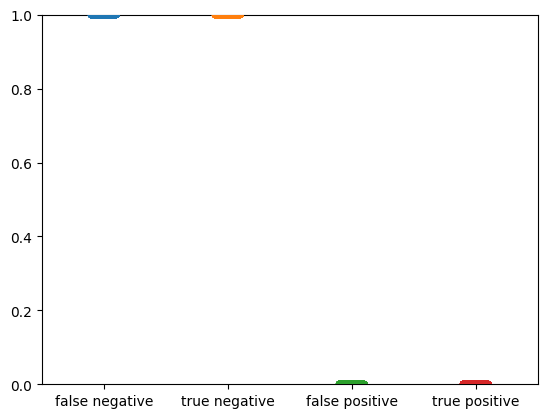

In [131]:
data = {'false negative': false_negative_probs,
               'true negative': true_negative_probs,
               'false positive': false_positive_probs,
               'true positive': true_positive_probs,
              }
cols = ['false negative', 'true negative', 'false positive', 'true positive']

df = pd.DataFrame.from_dict(
    data=dict(data),
    orient='index',
).T

fig, ax = plt.subplots()

ax = sns.stripplot(data=df)
ax.set_ylim(0, 1)

plt.show()


/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model:  KNN  score:  0.9382698194615181


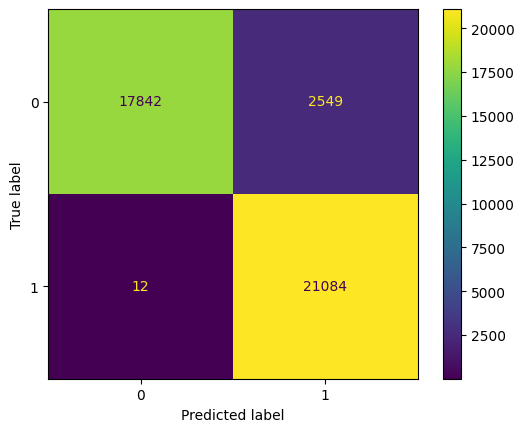

In [132]:
clf = KNeighborsClassifier(3)
clf = make_pipeline(StandardScaler(), clf)
clf.fit(normalize(X_train), y_train)
y_pred = clf.predict(normalize(X_test))
y_pred_prob = clf.predict_proba(X_test)

score = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
print("Model: ", "KNN", " score: ", score)

# # Fit logistic regression model
# model2 = KNeighborsClassifier(3)
# model2.fit(X_train, y_train)

# # Get confidence intervals for each prediction
# y_pred_prob = model2.predict_proba(X_test)
# # Get predicted values
# y_pred = model2.predict(normalize(X_test))

# # Get prediction accuracy
# score = accuracy_score(y_test, y_pred)
# # Get breakdown of false/true positives and false/true negatives
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Display results
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
# disp.plot()
# print("Model: ", "KNN", " score: ", score)


/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model:  Random Forest  score:  0.9897558271265697


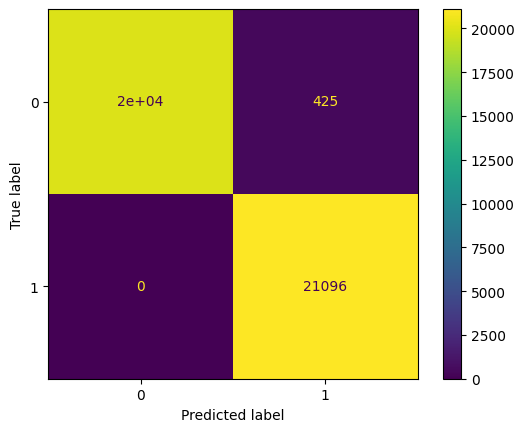

In [133]:
clf = m = RandomForestClassifier()
clf = make_pipeline(StandardScaler(), clf)
clf.fit(normalize(X_train), y_train)
y_pred = clf.predict(normalize(X_test))
y_pred_prob = clf.predict_proba(X_test)

score = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
disp.plot()
print("Model: ", "Random Forest", " score: ", score)


In [134]:
# Create lists of feature names and coefficients
column_labels = X_train.columns.tolist()
coef = m.feature_importances_

# Zip together
labels_coef = list(zip(column_labels, coef))
# Order by most significant features (positive or negative)
feature_ranks = sorted(labels_coef, key=lambda x: abs(x[1]), reverse=True)

print(feature_ranks)


[('age', 0.1527810645834945), ('educat', 0.13536358550060124), ('weight', 0.13280689728983253), ('height', 0.12861504930245238), ('gender', 0.11584814845906694), ('race', 0.11358371718912261), ('ethnic', 0.1135460702704646), ('wrkfarm', 0.022367399609832632), ('wrkchem', 0.015024101216268319), ('wrkpain', 0.011609967497522848), ('wrkasbe', 0.010805722806560013), ('wrkweld', 0.01070308290302182), ('wrkfoun', 0.009282186671829654), ('wrkbaki', 0.005869454648093907), ('wrkbutc', 0.005488401329074184), ('wrkfire', 0.004990110422753702), ('wrksand', 0.0033005580496142544), ('wrkflou', 0.0026026491072142564), ('wrkcott', 0.001962610503236321), ('wrkhard', 0.0017472940139340418), ('wrkcoal', 0.0017019286260093035)]


In [135]:
true_negative_probs = []
false_negative_probs = []
true_positive_probs = []
false_positive_probs = []

y_pred_list = y_pred.tolist()
y_pred_prob_list = y_pred_prob.tolist()
y_test_list = y_test['lung_cancer'].tolist()

for i in range(len(y_test)):
  # true negative
  if y_pred_list[i] == 0 and y_test_list[i] == 0:
    true_negative_probs.append(y_pred_prob_list[i][0])
  # false negative
  elif y_pred_list[i] == 0 and y_test_list[i] == 1:
    false_negative_probs.append(y_pred_prob_list[i][0])
  # true positive
  elif y_pred_list[i] == 1 and y_test_list[i] == 1:
    true_positive_probs.append(y_pred_prob_list[i][1])
  # false positive
  else:
    false_positive_probs.append(y_pred_prob_list[i][1])


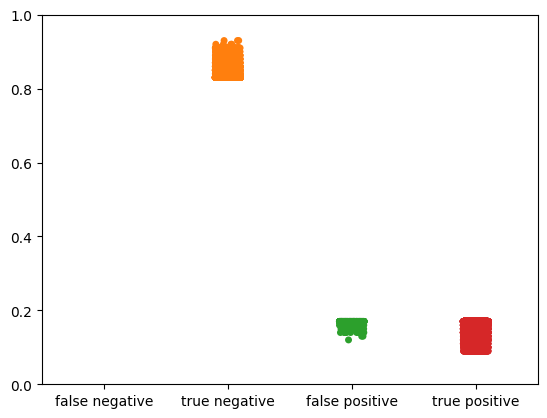

In [136]:
data = {'false negative': false_negative_probs,
               'true negative': true_negative_probs,
               'false positive': false_positive_probs,
               'true positive': true_positive_probs,
              }
cols = ['false negative', 'true negative', 'false positive', 'true positive']

df = pd.DataFrame.from_dict(
    data=dict(data),
    orient='index',
).T

fig, ax = plt.subplots()

ax = sns.stripplot(data=df)
ax.set_ylim(0, 1)

plt.show()


In [137]:
# from sklearn.svm import OneClassSVM

# clf = OneClassSVM(gamma='auto').fit(X_train)

# output = clf.predict(X_train)

# print()


In [138]:
# print(output)

# print(len(output))
# print(len(y_train))

# print(y_train)

# false_pos = 0
# false_neg = 0
# true_pos = 0
# true_neg = 0

# for i in range(len(output)):
#   if output[i] == 1 and y_train.iloc[i]['lung_cancer'] == 0:
#     true_neg += 1
#   elif output[i] == 1 and y_train.iloc[i]['lung_cancer'] == 1:
#     false_neg += 1
#   elif output[i] == -1 and y_train.iloc[i]['lung_cancer'] == 0:
#     false_pos += 1
#   else:
#     true_pos += 1

# print("false_pos: ", false_pos, " true_pos ", true_pos, " false_neg ", false_neg, " true_neg ", true_neg)


In [139]:
# scores = clf.score_samples(X_train)


In [140]:
# print(sorted(scores, reverse=True))

# new_output = output[:]

# for i in range(len(new_output)):
#   if scores[i] < 2 and new_output[i] == -1:
#     new_output[i] = 1
#   elif scores[i] >= 2 and new_output[i] == 1:
#     new_output[i] = -1

# false_pos = 0
# false_neg = 0
# true_pos = 0
# true_neg = 0

# for i in range(len(output)):
#   if new_output[i] == 1 and y_train.iloc[i]['lung_cancer'] == 0:
#     true_neg += 1
#   elif new_output[i] == 1 and y_train.iloc[i]['lung_cancer'] == 1:
#     false_neg += 1
#   elif new_output[i] == -1 and y_train.iloc[i]['lung_cancer'] == 0:
#     false_pos += 1
#   else:
#     true_pos += 1

# print("false_pos: ", false_pos, " true_pos ", true_pos, " false_neg ", false_neg, " true_neg ", true_neg)
